<a href="https://colab.research.google.com/github/eftekhar-hossain/Disaster_IEEE-Access/blob/main/damage_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from keras.utils.vis_utils import plot_model
np.random.seed(42)
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import string, spacy,unicodedata, random
from bs4 import BeautifulSoup
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings
pretrained_path = "/content/drive/MyDrive/TaheriThesis/Dataset/PreTrained Wordembedding/"
# dataset_path = "/content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/Images/"
# folder_path = "/content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/"
models_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/"


folder_path = "/content/drive/MyDrive/TaheriThesis/Dataset/"
# models_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models/"
# results_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Results/"
dataset_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Images/"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CPU times: user 9.51 s, sys: 1.42 s, total: 10.9 s
Wall time: 16.9 s


In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from keras.models import Model
from keras import preprocessing, Input
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
# from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.models import load_model
import itertools
from PIL import Image, ImageFile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D,MaxPooling1D,Conv1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Nadam
keras.backend.clear_session()

#Fetching Dataset

In [ ]:
# train_data = pd.read_excel(folder_path+'train.xlsx')
# test_data = pd.read_csv(folder_path+'test.xlsx')
# valid_data = pd.read_excel(main_path+'valid_new.xlsx')



train_data = pd.read_csv(folder_path+'train.csv')
valid_data = pd.read_csv(folder_path+'val.csv')
test_data = pd.read_csv(folder_path+'test.csv')



In [ ]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label'], dtype='object')

In [ ]:
train_data['Label'].value_counts()

0    861
6    716
4    623
1    477
5    408
3    400
2    348
Name: Label, dtype: int64

In [ ]:
test_data['Label'].value_counts()

0    93
6    79
4    68
5    46
3    44
1    44
2    40
Name: Label, dtype: int64

In [11]:



train_data['enc_label'] = train_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})
valid_data['enc_label'] = valid_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})
test_data['enc_label'] = test_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})

In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (3833, 5)
Size of the Test data ==> (414, 5)


## Image Fetching

In [12]:
## collect image names from the folders
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '' + file
            all_imgs.append(file)
    return all_imgs

def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '' + name for name in DF[Col_name]]
    return img_path

In [ ]:
# Creating train, test and validation image path
train_img_path = create_img_path(train_data,'image_name', dataset_path)
valid_img_path = create_img_path(valid_data,'image_name', dataset_path)

In [13]:
test_img_path = create_img_path(test_data,'image_name', dataset_path)

In [14]:
# Function that returns image reading from the path
def get_input(path):
    # Loading image from given path
    # and resizing it to 150*150*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img= tf.keras.utils.load_img(path, target_size=(150,150)) 
    # img.close()   
    return(img)

# Takes in image and preprocess it
def process_input(img):
    # Converting image to array    
    img_data =tf.keras.utils.img_to_array(img)
    # Adding one more dimension to array    
    img_data = np.expand_dims(img_data, axis=0)
    #     
    img_data = preprocess_input(img_data)
    #img_data = preprocess_input(img_data)
    return(img_data)


In [ ]:
# Create an array of training images
train_images = []
for n,i in enumerate(train_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  train_images.append(process_img[0])

In [ ]:
# Create an array of training images
valid_images = []
for n,i in enumerate(valid_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  valid_images.append(process_img[0])

In [15]:
# Create an array of training images
test_images = []
for n,i in enumerate(test_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  test_images.append(process_img[0])


In [ ]:
# convert into numpy array
train_image = np.array(train_images)

In [ ]:
valid_image = np.array(valid_images)

In [16]:
test_image = np.array(test_images)

In [ ]:
import pickle as pkl
with open(dataset_path+'train.pkl','wb') as f:
    pkl.dump(train_image, f)

# with open(dataset_path+'test.pkl','wb') as f:
#     pkl.dump(test_image, f)    

In [ ]:
import pickle as pkl
with open(dataset_path+'valid.pkl','wb') as f:
    pkl.dump(valid_image, f)

In [17]:
import pickle as pkl


with open(dataset_path+'test.pkl','wb') as f:
    pkl.dump(test_image, f)  

In [ ]:

with open(dataset_path+'train.pkl','rb') as f:
  train_image = pkl.load(f)
  print("Training Images:-- ",train_image.shape)

Training Images:--  (3833, 150, 150, 3)


In [ ]:

with open(dataset_path+'valid.pkl','rb') as f:
  valid_image = pkl.load(f)
  print("Validation Images:-- ",valid_image.shape)

Validation Images:--  (414, 150, 150, 3)


In [18]:
with open(dataset_path+'test.pkl','rb') as f:
  test_image = pkl.load(f)
  print("Test Images:-- ",test_image.shape)

Test Images:--  (414, 150, 150, 3)


## One Hot Encoding

In [19]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [20]:
# encoder=OneHotEncoder(sparse=False)

# encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

# encoded_labels .columns = encoder.get_feature_names(['label'])

# train_data= pd.concat([train_data, encoded_labels ], axis=1)

import pandas as pd

# Define the list of categories for your Label_Sentiment variable
categories = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

# Perform one-hot encoding using get_dummies() function
encoded_labels = pd.get_dummies(train_data['Label_Sentiment'], columns=categories, prefix='Label_Sentiment')

# Concatenate the encoded labels with your original train_data DataFrame
train_data = pd.concat([train_data, encoded_labels], axis=1)

In [21]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label', 'enc_label',
       'Label_Sentiment_angry', 'Label_Sentiment_disgust',
       'Label_Sentiment_fear', 'Label_Sentiment_happy',
       'Label_Sentiment_other', 'Label_Sentiment_sad',
       'Label_Sentiment_surprise'],
      dtype='object')

In [22]:
# train_data = train_data.rename(columns={'label_damaged_infrastructure':'damaged_infrastructure', 'label_damaged_nature':'damaged_nature', 
#                                         'label_fires':'fires','label_flood':'flood',
#                                         'label_human_damage':'human_damage', 'label_non_damage':'non_damage'})


train_data = train_data.rename(columns={'Label_Sentiment_happy':'happy', 
                                        'Label_Sentiment_angry':'angry',
                                        'Label_Sentiment_disgust':'disgust',
                                        'Label_Sentiment_fear':'fear',
                                        'Label_Sentiment_sad':'sad',
                                        'Label_Sentiment_surprise':'surprise',
                                        'Label_Sentiment_other':'other'})
     

train_data

,image_name,Captions,Label_Sentiment,Label,enc_label,angry,disgust,fear,happy,other,sad,surprise
0,205.jpg,নির্বোধ দেখার এবং আপনি যে যত্নশীল তা না করার ক...,other,6,6,0,0,0,0,1,0,0
1,209.jpg,একটি বোর্ডার আর্ম স্কেটার একটি আমন্ত্রণ উপার্জ...,other,6,6,0,0,0,0,1,0,0
2,210.jpg,যদি শরীর দুর্বল হয় তবে মন শক্তিশালী হবে না।,other,6,6,0,0,0,0,1,0,0
3,215.jpg,একজন ধার্মিক ব্যক্তির কার্যকর উত্সাহ প্রার্থনা...,other,6,6,0,0,0,0,1,0,0
4,222.jpg,অসমাপ্ত ?,other,6,6,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3828,4676.jpg,অভিনন্দন ২ প্রথম আইবিএম প্যাথওয়েসটেক পণ্ডিতরা...,happy,0,0,0,0,0,1,0,0,0
3829,4677.jpg,সবেমাত্র আমার চুলের সাথে রুটোশায়ার স্ক্যাল্প ...,happy,0,0,0,0,0,1,0,0,0
3830,4678.jpg,সবেমাত্র এই ওক ড্রেসারটি শেষ করেছেন।,happy,0,0,0,0,0,1,0,0,0
3831,4682.jpg,সুগারম্যান রজার্স মামলা-মোকদ্দমা কেমব্রিজে গত ...,happy,0,0,0,0,0,1,0,0,0


In [ ]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label', 'enc_label',
       'angry', 'disgust', 'fear', 'happy', 'other', 'sad', 'surprise'],
      dtype='object')

In [ ]:
train_data.Captions = train_data.Captions.astype(str)

## Text Cleaning

In [23]:

import locale
print(locale.getpreferredencoding())

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

ANSI_X3.4-1968


In [24]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.0-py2.py3-none-any.whl size=351211 sha256=43eccdbde0b8ef300f62467d0d7782cad9a87d0f13b84268eb9050d99468c04a
  Stored in directory: /root/.cache/pip/wheels/2a/0c/2c/07b5af72b120503fe24590691d24c462a25e5e530db8700a96
Successfully built emoji


In [ ]:
# stp_path = '/content/drive/MyDrive/TaheriThesis/Dataset/'
# stp = open(stp_path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()

In [25]:
'''
Text Cleaning
'''
import emoji
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def text_cleaning(row):
   #to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = d.replace('\r\n', '')
  post = post.replace('—', ' ') 
  post = post.replace('।', ' ')
  text = ''.join([c for c in post if c not in string.punctuation])
  text= remove_emojis(text)
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # # Stopword 
  # result = text.split()
  # text = [word.strip() for word in result if word not in stp ]
  # text =" ".join(text)
  
  return text

In [26]:
#Removing punctuations
train_data['cleaned'] = train_data['Captions'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['Captions'].apply(text_cleaning)
test_data['cleaned'] = test_data['Captions'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  if i in train_data.index:
    print("Original Data:===\n",train_data.Captions[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
 নির্বোধ দেখার এবং আপনি যে যত্নশীল তা না করার ক্ষমতা আছে 
Cleaned Data:===
 নির্বোধ দেখার এবং আপনি যে যত্নশীল তা না করার ক্ষমতা আছে
Original Data:===
 একটি বোর্ডার আর্ম স্কেটার একটি আমন্ত্রণ উপার্জন করবে? 
Cleaned Data:===
 একটি বোর্ডার আর্ম স্কেটার একটি আমন্ত্রণ উপার্জন করবে
Original Data:===
 যদি শরীর দুর্বল হয় তবে মন শক্তিশালী হবে না। 
Cleaned Data:===
 যদি শরীর দুর্বল হয় তবে মন শক্তিশালী হবে না
Original Data:===
 একজন ধার্মিক ব্যক্তির কার্যকর উত্সাহ প্রার্থনা অনেকটা উপকার পায়। 
Cleaned Data:===
 একজন ধার্মিক ব্যক্তির কার্যকর উত্সাহ প্রার্থনা অনেকটা উপকার পায়
Original Data:===
 অসমাপ্ত ? 
Cleaned Data:===
 অসমাপ্ত
Original Data:===
 আপনাকে পুরো হতে নিখুঁত হতে হবে না! 
Cleaned Data:===
 আপনাকে পুরো হতে নিখুঁত হতে হবে না
Original Data:===
 আজ আমাদের উঠোনে একটি ঠান্ডা, ক্লান্ত, ক্ষুধার্ত, আতঙ্কিত কালো বিড়াল পেয়েছে। সে সেখানে কয়েক দিন ছিল, কেউ তাকে মিস করছে? 
Cleaned Data:===
 আজ আমাদের উঠোনে একটি ঠান্ডা ক্লান্ত ক্ষুধার্ত আতঙ্কিত কা

##Evaluation Metrics

In [27]:
'''Evaluation Parameters'''

def print_metrices(true,pred):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred))
    print("Accuracy : ",accuracy_score(true,pred))
    print("Precison : ",precision_score(true,pred, average = 'weighted'))
    print("Recall : ",recall_score(true,pred,  average = 'weighted'))
    print("F1 : ",f1_score(true,pred,  average = 'weighted'))

## Confusion Matrix

In [28]:
## Confusion matrix function
def con_mat(true,pred,class_names,model_name):
  cm = confusion_matrix(true,pred)
  #sns.set()
  plt.figure(figsize =(4, 3))
  ax = plt.subplot()
 # 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
  sns.heatmap(cm, annot=True,fmt="d",cmap='YlOrRd', ax = ax,annot_kws={"size": 10},) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted labels',fontsize=10)
  ax.set_ylabel('True labels',fontsize=10) 
  #ax.set_title(f'Confusion Matrix of {model_name}',fontsize=10) 
  ax.xaxis.set_ticklabels(class_names, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
  ax.xaxis.tick_top()
 # plt.savefig(folder_path + f"{model_name}.png",bbox_inches='tight',dpi =500)

In [ ]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_data['enc_label']),
                                        y = train_data['enc_label']                                                   
                                    )
class_weights = dict(zip(np.unique(train_data['enc_label']), class_weights))
class_weights

{0: 0.6359714617554338,
 1: 1.147948487571129,
 2: 1.5734811165845648,
 3: 1.3689285714285715,
 4: 0.881757533931447,
 5: 1.3355400696864113,
 6: 0.7647645650438947}

#Textual Models

## Tokenizer

In [29]:
''' Tokenizer '''

def text_tokenizer(train_data,valid_data,test_data,vocabulary,max_len,sample_text_num):
  
  tokenizer = Tokenizer(num_words = vocabulary ,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                        split=' ', char_level=False, oov_token='<oov>', document_count=0)
  tokenizer.fit_on_texts(train_data['cleaned'])  
  word_index = tokenizer.word_index
  vocab_size = len(word_index)+1
  
  # Training Sequences
  train_sequences = tokenizer.texts_to_sequences(train_data['cleaned'])
  train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)


  valid_sequences = tokenizer.texts_to_sequences(valid_data['cleaned'])
  valid_pad_sequences =  keras.preprocessing.sequence.pad_sequences(valid_sequences, value=0.0, padding='post', maxlen= max_len)
  
  # Test Sequences
  test_sequences = tokenizer.texts_to_sequences(test_data['cleaned'])
  test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
 

  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")  
  print(train_data.cleaned[sample_text_num],"\n",train_sequences[sample_text_num])
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,"\n",train_pad_sequences[sample_text_num]) 

  return train_pad_sequences, valid_pad_sequences, test_pad_sequences, vocab_size, word_index


vocabulary = 50000 
max_len = 180 
sample_text_num = 10

## Call Tokenizer
train_pad_sequences,valid_pad_sequences, test_pad_sequences, vocab_size, word_index =  text_tokenizer(train_data,valid_data,test_data,
                                                                      vocabulary,max_len,sample_text_num) 

print("Number of Train Sequences :" ,train_pad_sequences.shape)
print("Number of Train Sequences :" ,valid_pad_sequences.shape)
print("Number of Test Sequences :" ,test_pad_sequences.shape)
print("Vocabulary Size: ",vocab_size)


			====== Encoded Sequences ====== 

আজ সকালে একটি অন্ধকার লন্ডন কলনিতে আর্সেনালের প্রথম দলের ট্রেন আশা করি আমিরাতরা আগামীকাল হতাশ হবে না 
 [31, 280, 6, 382, 1117, 4136, 4137, 152, 806, 807, 206, 18, 4138, 534, 72, 38, 5]

			====== Paded Sequences ======
 
 [  31  280    6  382 1117 4136 4137  152  806  807  206   18 4138  534
   72   38    5    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0

In [30]:
## Convert labels into array
y_train = np.array(train_data['enc_label']).reshape(-1,1)
y_valid = np.array(valid_data['enc_label']).reshape(-1,1)
y_test = np.array(test_data['enc_label']).reshape(-1,1)

## Callbacks

In [ ]:
''' Callbacks'''
keras.backend.clear_session()
def callbacks_check(model_name):
  num_classes = 7
  accuracy_threshold = 0.99

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  acc_callback = myCallback()
  # Saved the Best Model
  filepath = models_path+'Models_3/'+f"{model_name}.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
  # callback list
  callback_list = [acc_callback, checkpoint] 

  return callback_list

## Textual Models (Keras Embeddings)

In [ ]:
def create_keras_embeddings_models(max_len):

  ###### BiLSTM Model #######
  bi_text_inputs = Input(shape=(max_len,))
  bi_embedding_layer = Embedding(vocab_size, 100)(bi_text_inputs)
  LSTM_Layer_1 = Bidirectional(LSTM(128,dropout=0.01))(bi_embedding_layer)
  bi_dense_layer_1 = Dense(7, activation='softmax')(LSTM_Layer_1)
  bilstm_model = Model(inputs=bi_text_inputs, outputs=bi_dense_layer_1)

  ##### CNN Model  #######
  cnn_text_inputs = Input(shape=(max_len,))
  cnn_embedding_layer = Embedding(vocab_size, 100)(cnn_text_inputs)
  cnn_conv1 = Conv1D(128,2,activation='relu')(cnn_embedding_layer)
  cnn_pool1 = MaxPooling1D(2)(cnn_conv1)
  cnn_flat = Flatten()(cnn_pool1)
  cnn_dense_layer_1 = Dense(7, activation='softmax')(cnn_flat)
  cnn_model = Model(inputs=cnn_text_inputs, outputs=cnn_dense_layer_1)


 

  return models

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(train_data['enc_label'])
y_valid=to_categorical(valid_data['enc_label'])
y_test=to_categorical(test_data['enc_label'])

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#Visual Models

In [ ]:
keras.backend.clear_session()

def visual_models():

  # create the base pre-trained model
  vgg = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  for layer in vgg.layers:
      layer.trainable = True
  # add a global spatial average pooling layer
  x = vgg.output
  pool = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  #flat = Flatten()(pool)
  # and a logistic layer -- let's say we have 200 classes
  #hidden1 = Dense(512, activation='relu')(flat)
  #dropout = Dropout(0.1)(hidden1)
  output = Dense(7, activation='softmax')(pool)
  # this is the model we will train
  vgg_img_model = Model(inputs=vgg.input, outputs=output)

  #### Resnet
  resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  #resnet.trainable = False
  for layer in resnet.layers[0:-10]:
      layer.trainable = False
  # add a global spatial average pooling layer
  y = resnet.output
  pool1 = GlobalAveragePooling2D()(y)
  # let's add a fully-connected layer
  #flat1 = Flatten()(pool1)
  # and a logistic layer -- let's say we have 200 classes
  #hidden = Dense(512, activation='relu')(flat1)
  #dropout1 = Dropout(0.1)(hidden)
  output1 = Dense(7, activation='softmax')(pool1)
  # this is the model we will train
  resnet_img_model = Model(inputs=resnet.input, outputs=output1)

  models = [vgg_img_model,resnet_img_model]

  return models


In [ ]:
## Inception V3
def inception_model():
# create the base pre-trained model
  inception = keras.applications.InceptionV3(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  for layer in inception.layers:
    layer.trainable = True
  # add a global spatial average pooling layer
  w = inception.output
  pool = GlobalAveragePooling2D()(w)
  output = Dense(7, activation='softmax')(pool)
  # this is the model we will train
  inception_img_model = Model(inputs=inception.input, outputs=output)
  return inception_img_model

## Multimodal Models

In [ ]:
visual_model_name = ['vgg16','resnet']
visual_models_lsit = visual_models()

# textual_model_name = ['LSTM','CNN','CNN_LSTM']
textual_model_name = ['LSTM','CNN']
text_models_list = create_keras_embeddings_models(180)


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
for vm,visual_model in enumerate(visual_models_lsit):
  for tm,textual_model in enumerate(text_models_list):
    # Concatenating the output of 2 classifiers
    con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
    dropout = Dropout(0.2)(con_layer)
    final_dense = Dense(64, activation="relu")(dropout)
    out = Dense(7,activation='softmax')(final_dense)
     
    #Defining model input and output
    com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
    if visual_model == 'vgg16':
      opt = RMSprop()
    else:
      opt = Adam() 
      
    com_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ["accuracy"])
    print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
    com_model.fit([train_image,train_pad_sequences],
    y_train,
    epochs=50,
    batch_size =32,
    validation_data=([valid_image,valid_pad_sequences],y_valid),
    verbose =1,
    class_weight = class_weights,
    callbacks = callbacks_check(visual_model_name[vm]+textual_model_name[tm]))

Model Name: vgg16+LSTM

Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 1.9185 - accuracy: 0.1972
Epoch 1: val_accuracy improved from -inf to 0.21981, saving model to /content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models_3/vgg16LSTM.h5
120/120 [==============================] - 82s 395ms/step - loss: 1.9185 - accuracy: 0.1972 - val_loss: 1.8732 - val_accuracy: 0.2198
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 1.8172 - accuracy: 0.2708
Epoch 2: val_accuracy improved from 0.21981 to 0.35024, saving model to /content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models_3/vgg16LSTM.h5
120/120 [==============================] - 36s 304ms/step - loss: 1.8172 - accuracy: 0.2708 - val_loss: 1.7123 - val_accuracy: 0.3502
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 1.6563 - accuracy: 0.3352
Epoch 3: val_accuracy improved from 0.35024 to 0.36715, saving model to /content/drive/MyDrive/TaheriThes

## Multimodal Models Performance

In [ ]:
multimodal_models = ['vgg16LSTM','vgg16CNN','resnetLSTM','resnetCNN']
multimodal_names =  ['VGG16+LSTM','VGG16+CNNText','ResNet+LSTM','ResNet+CNNText']

def multimodal_models_accuracy(saved_model): 
  my_dict = {}
  # Prediction 
  model = load_model(models_path+'Models_3/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100 
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100 
  return my_dict

In [ ]:
accuracy = {f'{multimodal_names[i]}':multimodal_models_accuracy(model) for i,model in enumerate(multimodal_models)}
# Save the performance parameter into json file
with open(models_path+'Results_3/'+'multimodal_models_performance.json', 'w') as f:
    json.dump(accuracy, f)

13/13 [==============================] - 2s 53ms/step


In [ ]:
# Load the json file
metrics = json.load(open(models_path+'Results_3/'+'multimodal_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Multimodal Models Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =multimodal_names)
performance_matrix

=======  Multimodal Models Performance on Test Data  =============



,Accuracy,Precision,Recall,F1 Score
VGG16+LSTM,74.88,78.18,74.88,75.73
VGG16+CNNText,73.91,78.30,73.91,74.49
ResNet+LSTM,75.60,77.08,75.60,75.87
ResNet+CNNText,74.15,77.20,74.15,74.38


## Error Analysis (Quantative)

In [ ]:
models = ['vgg16LSTM','vgg16CNN','resnetLSTM','resnetCNN']
model_names = ['VGG16+LSTM','VGG16+CNNText','ResNet+LSTM','ResNet+CNNText']
class_names = ['happy','angry','disgust','fear','sad','surprise','other']
def models_confusion_matrix(saved_model,model_name): 

  # if saved_model == 'vgg16LSTM':
    # model = visual_models()
    model=load_model(models_path+'Models_3/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  


    y_true = test_data['enc_label']
    con_mat(y_true,y_pred,class_names,model_name)  





======= Confusion Matrix of best Models  =============

13/13 [==============================] - 2s 54ms/step


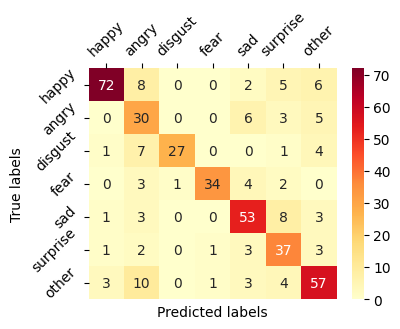

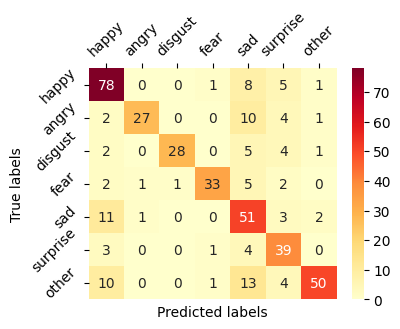

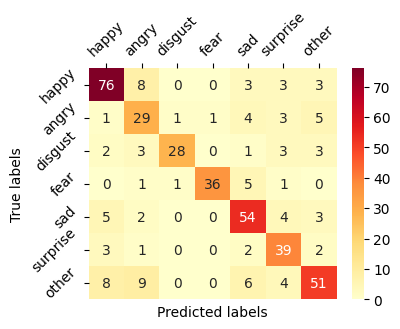

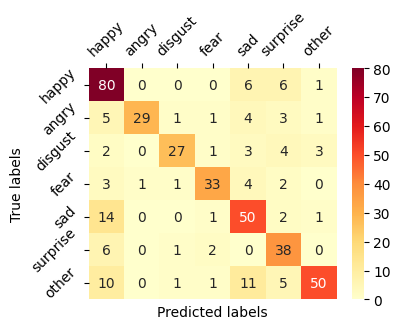

In [ ]:
print (color.BOLD+f"======= Confusion Matrix of best Models  =============\n"+color.END)
for i,model in enumerate(models):
    models_confusion_matrix(model,model_names[i])

## Feature Visualization

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(train_data['enc_label'])
y_test=to_categorical(test_data['enc_label'])

In [ ]:

# Load the saved model
model=load_model(models_path+'Models_3/'+ 'resnetLSTM.h5') 
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

13/13 [==============================] - 2s 57ms/step


In [ ]:
model = load_model(models_path+'Models_3/'+ 'vgg16LSTM.h5') 
for layer in model.layers:
    print(layer.name, layer.trainable)
    print('Layer Configuration:')
    print(layer.get_config(), end='\n{}\n'.format('----'*10))

input_1 True
Layer Configuration:
{'batch_input_shape': (None, 150, 150, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}
----------------------------------------
block1_conv1 True
Layer Configuration:
{'name': 'block1_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
----------------------------------------
block1_conv2 True
Layer Configuration:
{'name': 'block1_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels

In [ ]:
def create_truncated_model(trained_model):
    
    #model = load_model(folder_path+'Models_2/'+'vgg16.h5')
    #
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

# model = create_lstm_attention_resnet_model()
# model.load_weights(folder_path+'Models_2/'+ 'resnet_lstm_att.h5') 

model = load_model(models_path+'Models_3/'+'resnetLSTM.h5')

truncated_model = create_truncated_model(model)
hidden_features = truncated_model.predict([test_image,test_pad_sequences])

13/13 [==============================] - 2s 61ms/step


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=5)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, perplexity=20, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)

Variance PCA: 0.9203045964241028
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 414 samples in 0.013s...
[t-SNE] Computed neighbors for 414 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 414 / 414
[t-SNE] Mean sigma: 0.000011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.397621
[t-SNE] KL divergence after 1000 iterations: 0.112561


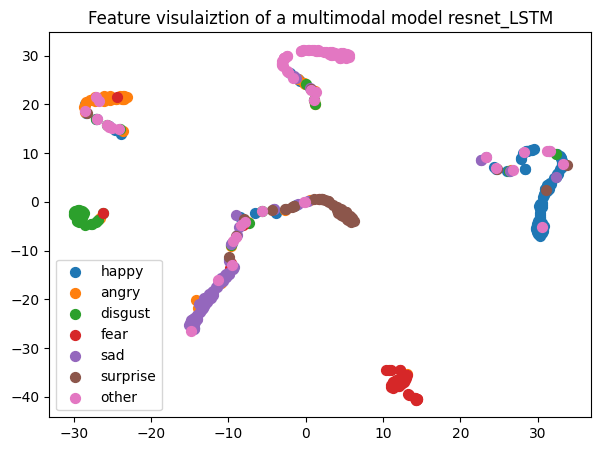

In [ ]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(test_data['enc_label'], num_classes = 7)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(7,5))
class_labels = ['happy','angry','disgust','fear','sad','surprise','other']
for i,cl in enumerate(range(7)):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=class_labels[i],marker='o',s=50)
plt.title('Feature visulaiztion of a multimodal model resnet_LSTM')    
plt.legend()
plt.savefig(folder_path+'fv.png',dpi = 700,bbox_inches ='tight')
plt.show()



In [ ]:
# from keras.utils import np_utils
# import matplotlib.pyplot as plt
# %matplotlib inline

# y_test_cat = np_utils.to_categorical(test_data['enc_label'], num_classes = 7)
# color_map = np.argmax(y_test_cat, axis=1)
# plt.figure(figsize=(7,5))
# class_labels = ['happy','angry','disgust','fear','sad','surprise','other']
# for i,cl in enumerate(range(7)):
#     indices = np.where(color_map==cl)
#     indices = indices[0]
#     plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=class_labels[i],marker='o',s=50)
# plt.title('Feature visulaiztion of the proposed model (with attention)')    
# plt.legend()
# plt.savefig(folder_path+'fv-a.png',dpi = 700,bbox_inches ='tight')
# plt.show()



In [ ]:
text_models_list

In [ ]:
### Multimodal models with Inception 

visual_model_name = ['inception']
visual_models_list = [inception_model()]

# textual_model_name = ['LSTM','CNN', 'LSTM-CNN']
textual_model_name = ['LSTM','CNN']
text_models_list = create_keras_embeddings_models(180)

# keras.backend.clear_session()

# for vm,visual_model in enumerate(visual_models_list):
#   for tm,textual_model in enumerate(text_models_list):
#     # Concatenating the output of 2 classifiers
#     con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
#     #dropout = Dropout(0.2)(con_layer)
#     #final_dense = Dense(64, activation="relu")(dropout)
#     out = Dense(6,activation='softmax')(con_layer)
     
#     #Defining model input and output
#     com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
      
#     com_model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics = ["accuracy"])
#     print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
#     com_model.fit([train_image,train_pad_sequences],
#     train_data['enc_label'],
#     epochs=50,
#     batch_size =64,
#     validation_split=0.1,
#     verbose =1,
#     callbacks = callbacks_check(visual_model_name[vm] + textual_model_name[tm]))


# visual_model = inception_model()
# textual_model = text_models_list[2]

# # Concatenating the output of 2 classifiers
# con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
# #dropout = Dropout(0.2)(con_layer)
# #final_dense = Dense(64, activation="relu")(dropout)
# out = Dense(7,activation='softmax')(con_layer)
     
#     #Defining model input and output
# com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
      
# com_model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics = ["accuracy"])
#     #print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
# com_model.fit([train_image,train_pad_sequences],
#   train_data['enc_label'],
#     epochs=50,
#     batch_size =32,
#     validation_data=([valid_image,valid_pad_sequences],y_valid),
#     verbose =1,
#     callbacks = callbacks_check('inception+bilstm-CNN'))





87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for vm,visual_model in enumerate(visual_models_list):
  for tm,textual_model in enumerate(text_models_list):
    # Concatenating the output of 2 classifiers
    con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
    dropout = Dropout(0.2)(con_layer)
    final_dense = Dense(64, activation="relu")(dropout)
    out = Dense(7,activation='softmax')(final_dense)
     
    #Defining model input and output
    com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
    if visual_model == 'vgg16':
      opt = RMSprop()
    else:
      opt = Adam() 
      
    com_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ["accuracy"])
    print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
    com_model.fit([train_image,train_pad_sequences],
    y_train,
    epochs=50,
    batch_size =32,
    validation_data=([valid_image,valid_pad_sequences],y_valid),
    verbose =1,
    class_weight = class_weights,
    callbacks = callbacks_check(visual_model_name[vm]+textual_model_name[tm]))

Model Name: inception+LSTM

Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 1.9063 - accuracy: 0.2092
Epoch 1: val_accuracy improved from -inf to 0.21981, saving model to /content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models_3/inceptionLSTM.h5
120/120 [==============================] - 84s 323ms/step - loss: 1.9063 - accuracy: 0.2092 - val_loss: 1.9156 - val_accuracy: 0.2198
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 1.9003 - accuracy: 0.2249
Epoch 2: val_accuracy did not improve from 0.21981
120/120 [==============================] - 19s 158ms/step - loss: 1.9003 - accuracy: 0.2249 - val_loss: 1.9160 - val_accuracy: 0.2198
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 1.9027 - accuracy: 0.2241
Epoch 3: val_accuracy did not improve from 0.21981
120/120 [==============================] - 17s 139ms/step - loss: 1.9027 - accuracy: 0.2241 - val_loss: 1.9147 - val_accuracy: 0.2198
Epoch 4/50
120/120 [

In [ ]:
# multimodal_models = ['inceptionLSTM','inceptionCNN','inceptionLSTM-CNN']
# multimodal_names =  ['inception+LSTM','inception+CNNText','inception+LSTM-CNN']
multimodal_models = ['inceptionLSTM','inceptionCNN']
multimodal_names =  ['inception+LSTM','inception+CNNText']

def multimodal_models_accuracy(saved_model): 
  my_dict = {}
  # Prediction 
  model = load_model(models_path+'Models_3/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100 
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100 
  return my_dict

In [ ]:
accuracy = {f'{multimodal_names[i]}':multimodal_models_accuracy(model) for i,model in enumerate(multimodal_models)}
# Save the performance parameter into json file
with open(models_path+'Results_3/'+'multimodal_models_performance.json', 'w') as f:
    json.dump(accuracy, f)

13/13 [==============================] - 2s 37ms/step


In [ ]:
# Load the json file
metrics = json.load(open(models_path+'Results_3/'+'multimodal_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Multimodal Models Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =multimodal_names)
performance_matrix

=======  Multimodal Models Performance on Test Data  =============



,Accuracy,Precision,Recall,F1 Score
inception+LSTM,74.4,79.87,74.4,75.39
inception+CNNText,71.5,73.89,71.5,72.05


In [ ]:
# models = ['inceptionLSTM','inceptionCNN','inceptionLSTM-CNN']
# model_names = ['inception+LSTM','inception+CNNText','inception+LSTM-CNN']
models = ['inceptionLSTM','inceptionCNN']
model_names = ['inception+LSTM','inception+CNNText']
class_names = ['happy','angry','disgust','fear','sad','surprise','other']
def models_confusion_matrix(saved_model,model_name): 

  # if saved_model == 'vgg16LSTM':
    # model = visual_models()
    model=load_model(models_path+'Models_3/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  


    y_true = test_data['enc_label']
    con_mat(y_true,y_pred,class_names,model_name)  


======= Confusion Matrix of best Models  =============

13/13 [==============================] - 2s 37ms/step


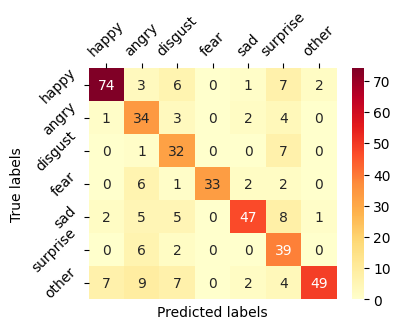

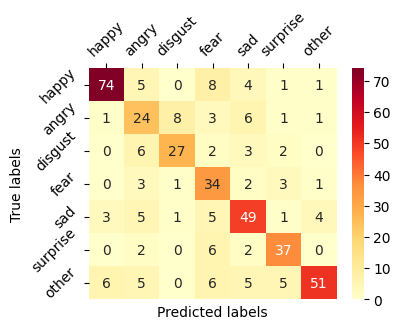

In [ ]:
print (color.BOLD+f"======= Confusion Matrix of best Models  =============\n"+color.END)
for i,model in enumerate(models):
    models_confusion_matrix(model,model_names[i])

In [31]:
from sklearn.metrics import matthews_corrcoef

multimodal_models = ['vgg16LSTM','vgg16CNN','resnetLSTM','resnetCNN','inceptionLSTM','inceptionCNN']
multimodal_names =  ['VGG16+LSTM','VGG16+CNNText','ResNet+LSTM','ResNet+CNNText','inception+LSTM','inception+CNNText']
class_names = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

def multimodal_models_metrics_MCC(saved_model, model_name):
  model = load_model(models_path + 'Models_3/' + f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)
  y_true = test_data['enc_label']

 

  # Calculate MCC
  mcc = matthews_corrcoef(y_true, y_pred)
  print(f"MCC for {model_name}: {mcc}")

print(f"{color.BOLD}======= Matrices for Visual Models  ============={color.END}")
for i, model in enumerate(multimodal_models):
  multimodal_models_metrics_MCC(model, multimodal_names[i])

======= Matrices for Visual Models  =============
13/13 [==============================] - 18s 275ms/step
MCC for VGG16+LSTM: 0.705292006637807
13/13 [==============================] - 1s 78ms/step
MCC for VGG16+CNNText: 0.6939697510335527
13/13 [==============================] - 4s 112ms/step
MCC for ResNet+LSTM: 0.711664120958835
13/13 [==============================] - 2s 56ms/step
MCC for ResNet+CNNText: 0.6956131945424865
13/13 [==============================] - 5s 126ms/step
MCC for inception+LSTM: 0.7050187657733348
13/13 [==============================] - 3s 39ms/step
MCC for inception+CNNText: 0.6661517212455609
